In [13]:
import numpy as np
import time
from matplotlib import pyplot as plt
from scipy.linalg import lu

In [14]:
global flops
flops = 0
def add_matrices(A,B):
    global flops
    flops += A.size
    return np.add(A,B)

def subtract_matrices(A, B):
    global flops
    flops += A.size 
    return np.subtract(A, B)

In [15]:
def strassen_alg(A1, B1):
    global flops
    def strassen_core(A, B):
        global flops

        if(A.shape[0] == 1):

            C = np.multiply(A, B.transpose())
            flops += A.shape[1]
            return C
        
        n_prev = A.shape[0]
        m_prev = B.shape[1]

        """
        if(A.shape[0] % 2):
            A = np.pad(A, ((0, 1), (0, 0)), mode = "constant", constant_values = 0)
        if(A.shape[1] % 2):
            A = np.pad(A, ((0, 0), (0, 1)), mode = "constant", constant_values = 0)
        if(B.shape[0] % 2):
            B = np.pad(B, ((0, 1), (0, 0)), mode = "constant", constant_values = 0)
        if(B.shape[1] % 2):
            B = np.pad(B, ((0, 0), (0, 1)), mode = "constant", constant_values = 0)

            
        w1 = A.shape[0]//2
        k1 = A.shape[1]//2
        w2 = B.shape[0]//2
        k2 = B.shape[1]//2
        """
        
        mid = A.shape[0]//2

        A00 = A[:mid, :mid]
        A01 = A[:mid, mid:]
        A10 = A[mid:, :mid]
        A11 = A[mid:, mid:]

        B00 = B[:mid, :mid]
        B01 = B[:mid, mid:]
        B10 = B[mid:, :mid]
        B11 = B[mid:, mid:]

        M1 = strassen_core(add_matrices(A00, A11), add_matrices(B00, B11))
        M2 = strassen_core(add_matrices(A10, A11), B00)
        M3 = strassen_core(A00, subtract_matrices(B01, B11))
        M4 = strassen_core(A11, subtract_matrices(B10, B00))
        M5 = strassen_core(add_matrices(A00, A01), B11)
        M6 = strassen_core(subtract_matrices(A10, A00), add_matrices(B00, B01))
        M7 = strassen_core(subtract_matrices(A01, A11), add_matrices(B10, B11))

        result = np.zeros((2 * mid, 2 * mid), dtype=np.longdouble)
        result[:mid, :mid] = add_matrices(add_matrices(M1, M4), subtract_matrices(M7, M5))
        result[:mid, mid:] = add_matrices(M3, M5)
        result[mid:, :mid] = add_matrices(M2, M4)
        result[mid:, mid:] = add_matrices(subtract_matrices(M1, M2), add_matrices(M3, M6))
        return result[:n_prev, :m_prev]
    
    pot = 1
    max_shape = max(max(A1.shape), max(B1.shape))
    while(pot < max_shape):
        pot *= 2
    B1_prev = B1.shape[1]
    A1_prev = A1.shape[0]
    B1 = np.pad(B1, ((0, pot - B1.shape[0]), (0, pot - B1.shape[1])), mode = "constant", constant_values = 0)
    A1 = np.pad(A1, ((0, pot - A1.shape[0]), (0, pot - A1.shape[1])), mode = "constant", constant_values = 0)
    res1 = strassen_core(A1, B1)
    return res1[:A1_prev, :B1_prev]

In [16]:
def inverse_recursive(A1, mult_alg):
    n = A1.shape[0]
    if(n == 1):
        return 1/A1
    mid = n//2
    
    A11 = A1[:mid, :mid]
    A12 = A1[:mid, mid:]
    A21 = A1[mid:, :mid]
    A22 = A1[mid:, mid:]

    A11_inv = inverse_recursive(A11, mult_alg)

    S22 = subtract_matrices(A22, mult_alg(mult_alg(A21, A11_inv), A12))

    S22_inv = inverse_recursive(S22, mult_alg)
    
    B11 = mult_alg(A11_inv, add_matrices(np.identity(mid), mult_alg(mult_alg(A12, S22_inv), mult_alg(A21, A11_inv))))
    B12 = (-1) * mult_alg(mult_alg(A11_inv, A12), S22_inv)
    B21 = (-1) * mult_alg(mult_alg(S22_inv, A21), A11_inv)
    B22 = S22_inv
    result = np.zeros((n, n), dtype=np.longdouble)
    result[:mid, :mid] = B11
    result[:mid, mid:] = B12
    result[mid:, :mid] = B21
    result[mid:, mid:] = B22
    return result[:n, :n]



In [17]:
def LU_factor(A, mult_alg):

    n = A.shape[0]
    if(n == 1):
        return A, np.array([[1]])
    
    mid = n//2
    A11 = A[:mid, :mid]
    A12 = A[:mid, mid:]
    A21 = A[mid:, :mid]
    A22 = A[mid:, mid:]


    L11, U11 = LU_factor(A11, mult_alg)
    U11_inv = inverse_recursive(U11, mult_alg)
    L21 = mult_alg(A21, U11_inv)
    L11_inv = inverse_recursive(L11, mult_alg)
    U12 = mult_alg(L11_inv, A12)
    S = subtract_matrices(A22, mult_alg(mult_alg(mult_alg(A21, U11_inv), L11_inv), A12))
    Ls, Us = LU_factor(S, mult_alg)
    U22 = Us
    L22 = Ls
    
    U_res = np.zeros((n, n), dtype=np.longdouble)
    U_res[:mid, :mid] = U11
    U_res[:mid, mid:] = U12
    U_res[mid:, mid:] = U22
    L_res = np.zeros((n, n), dtype=np.longdouble)
    L_res[:mid, :mid] = L11
    L_res[mid:, :mid] = L21
    L_res[mid:, mid:] = L22
    return L_res[:n, :n], U_res[:n, :n]


In [18]:
def matrix_naive(A, B):
    global flops
    n = A.shape[0]
    if(len(B.shape) == 1):
        B = np.expand_dims(B, axis=1)
    m = B.shape[1]
    res = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            for k in range(A.shape[1]):
                res[i, j] += A[i, k] * B[k, j]
                flops += 2
    return res

In [19]:
def Gauss_recursive(A, B, mult_alg):

    
    n = len(A)
    if(n == 1):
        return A, B
    mid = n//2

    A11 = A[:mid, :mid]
    A12 = A[:mid, mid:]
    A21 = A[mid:, :mid]
    A22 = A[mid:, mid:]

    b1 = B[:mid, 0]
    b2 = B[mid:, 0] 

    L11, U11 = LU_factor(A11, mult_alg)
    L11_inv = inverse_recursive(L11, mult_alg)
    U11_inv = inverse_recursive(U11, mult_alg)
    S = subtract_matrices(A22, mult_alg(mult_alg(mult_alg(A21, U11_inv), L11_inv), A12))
    Ls, Us = LU_factor(S, mult_alg)
    Ls_inv = inverse_recursive(Ls, mult_alg)

    C11 = U11
    C12 = mult_alg(L11_inv, A12)
    C22 = Us

    b1_new = matrix_naive(L11_inv, b1)
    b2_new = subtract_matrices(matrix_naive(Ls_inv, b2), matrix_naive(mult_alg(mult_alg(mult_alg(Ls_inv, A21), U11_inv), L11_inv ), b1 ))

    Gauss_res = np.zeros((n, n), dtype=np.longdouble)
    Gauss_res[:mid, :mid] = C11
    Gauss_res[:mid, mid:] = C12
    Gauss_res[mid:, mid:] = C22
    Gauss_res[mid:, :mid] = np.zeros((n-mid, mid))
    
    B_res = np.zeros((n, 1))
    B_res[:mid] = b1_new
    B_res[mid:] = b2_new

    return Gauss_res[:n, :n], B_res[:n, 0]



In [20]:
def determinant_recursive(A, mult_alg):
    global flops
    res = 1.0
    L, U = LU_factor(A, mult_alg)
    for i in range(A.shape[0]):
        res *= L[i, i] * U[i, i]
        flops += 2
    return res

In [21]:


n = 8
rng = np.random.default_rng()

x = (rng.random((n, n)) * (1 - 1e-8) + 1e-8).astype(np.longdouble)
y = (rng.random((n, 20)) * (1 - 1e-8) + 1e-8).astype(np.longdouble)
b_ = (rng.random((n, 1)) * (1 - 1e-8) + 1e-8).astype(np.longdouble)

mult_res = strassen_alg(x, y)

delta_mult = mult_res - np.matmul(x, y)

print(delta_mult[abs(delta_mult) > 1e-4])
print("")

my_inv = inverse_recursive(x,strassen_alg)
delta_inv = abs(my_inv - np.linalg.inv(x.astype(np.double)))

print(delta_inv[delta_inv >= 1e-6])
print("")

L1, U1 = LU_factor(x, strassen_alg)

#print(L1)
#print("\n")
#print(U1)

print(U1)






print("")

g_res, b_res = Gauss_recursive(x, b_, strassen_alg)

for j in range(g_res.shape[1]):
    for i in range(j+1, g_res.shape[0]):
        assert (g_res[i, j] <= 1e-12)

solve1 = np.linalg.solve(g_res.astype(np.double),b_res.astype(np.double))
solve2 = np.linalg.solve(x.astype(np.double),b_.astype(np.double))
print(abs(solve1-solve2.flatten()).sum())
print("")

#print(g_res)
#print("")

print(b_res)
print("")


print("det difference: ", determinant_recursive(x, strassen_alg) - np.linalg.det(x.astype(np.double)))



[]

[]

[[ 1.          1.66125048  0.4922699   1.05180341  1.56247287  0.13636082
   0.05862627  1.36864535]
 [ 0.          1.         -0.23975229  0.23593283  0.644403   -0.06702175
  -0.23643052  0.54587089]
 [ 0.          0.          1.          0.46974293 -0.0787073   0.47970689
   0.45100487 -1.09044003]
 [ 0.          0.          0.          1.          0.92747178 -3.81123976
  -3.46830458  1.83026177]
 [ 0.          0.          0.          0.          1.         -0.48623402
  -0.59876457 -0.07897427]
 [ 0.          0.          0.          0.          0.          1.
   0.33567038  0.51761845]
 [ 0.          0.          0.          0.          0.          0.
   1.         -0.81962366]
 [ 0.          0.          0.          0.          0.          0.
   0.          1.        ]]

6.689093723366568e-15

[ 1.24932542  0.13558667 -0.69420641  1.07529693  0.1406428   0.14154917
  0.10125185  0.63603694]

det difference:  1.942890293094024e-16


In [22]:
def g(x):
    return x**(2.807)

In [29]:
def plot_times(sizes, times, flops, algorithm_name, est = g, const = 16):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    res_g, res_flops = [], []
    for n in sizes:
        res_g.append(const*g(n))

    ax1.plot(sizes, times)
    ax1.set_xlabel('Matrix Size')
    ax1.set_ylabel('Time (s)')
    ax1.set_title(f'Execution Time of Algorithm: {algorithm_name}')
    ax1.grid(True)

    ax2.plot(sizes, flops)
    #ax2.plot(sizes, res_g)
    ax2.set_xlabel('Matrix Size')
    ax2.set_ylabel('FLOPS')
    ax2.set_title(f'FLOPS for Algorithm: {algorithm_name}')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

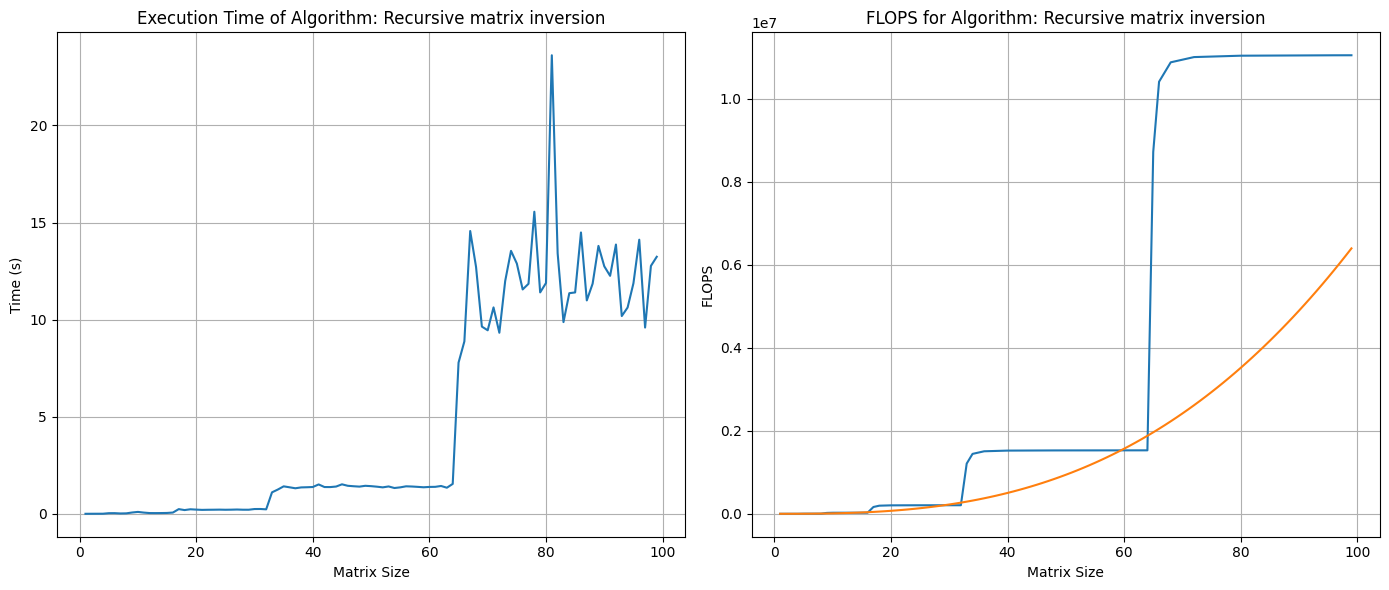

In [28]:
def measure_times_inverse(sizes):
    T_times = []
    T_flops = []
    
    for n in sizes:
        rng = np.random.default_rng()

        A = (rng.random((n, n)) * (1 - 1e-8) + 1e-8).astype(np.longdouble)
        
        global flops
        flops = 0
        start_time = time.time()
        A_inv = inverse_recursive(A, strassen_alg) 
        
        print(n, end = ' ')
        T_times.append(time.time() - start_time)

        delta_inv = abs(A_inv - np.linalg.inv(A.astype(np.double)))
        assert len(delta_inv[delta_inv >= 1e-2]) == 0
        
        T_flops.append(flops)
        
    return T_times, T_flops

sizes = list(range(1, 100))  
inverse_times, inverse_flops = measure_times_inverse(sizes)
plot_times(sizes, inverse_times, inverse_flops, "Recursive matrix inversion")


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

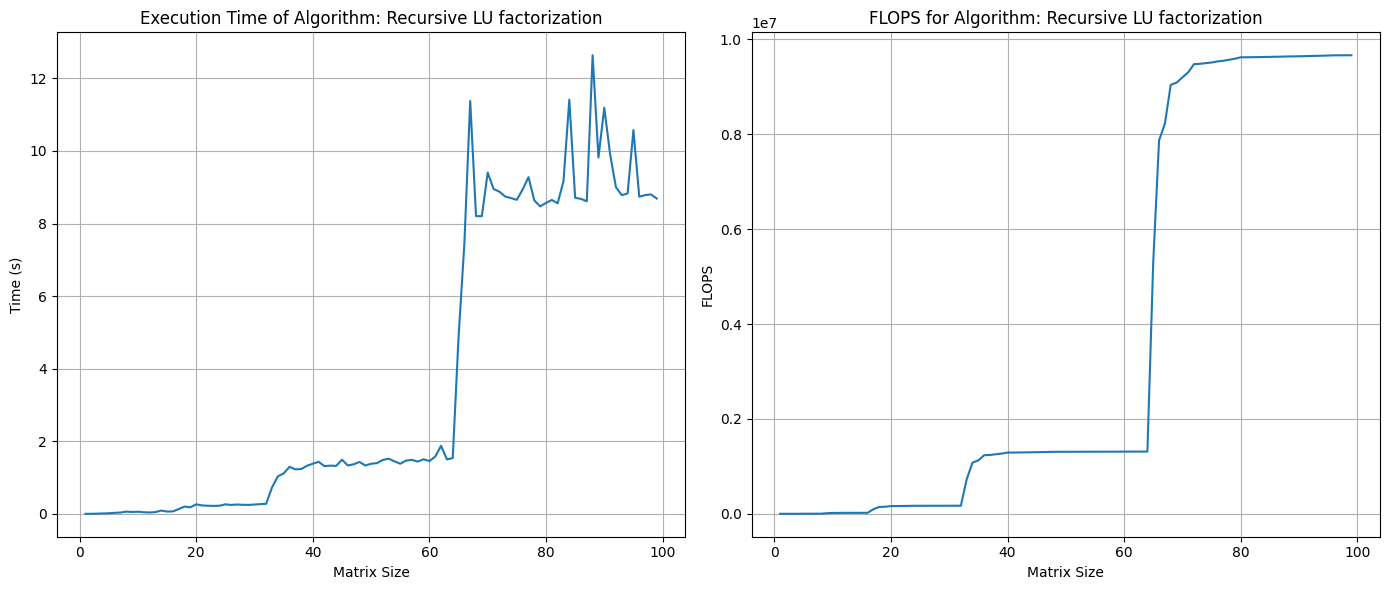

In [31]:
def measure_times_LU_factor(sizes):
    T_times = []
    T_flops = []
    
    for n in sizes:
        rng = np.random.default_rng()

        A = (rng.random((n, n)) * (1 - 1e-8) + 1e-8).astype(np.longdouble)
        
        global flops
        flops = 0
        start_time = time.time()
        L1, U1 = LU_factor(A, strassen_alg) 

        print(n, end = ' ')
        T_times.append(time.time() - start_time)

        delta_LU = abs(A - np.matmul(L1.astype(np.double), U1.astype(np.double)))
        
        for j in range(U1.shape[1]):
            for i in range(j+1, U1.shape[0]):
                assert (U1[i, j] <= 1e-6)

        for j in range(L1.shape[1]):
            for i in range(j-1, -1, -1):
                assert (L1[i, j] <= 1e-6)
        
        assert delta_LU.max() <= 1e-4
        
        T_flops.append(flops)
        
    return T_times, T_flops

sizes = list(range(1, 100))  
lu_times, lu_flops = measure_times_LU_factor(sizes)
plot_times(sizes, lu_times, lu_flops, "Recursive LU factorization", const = 13.4)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

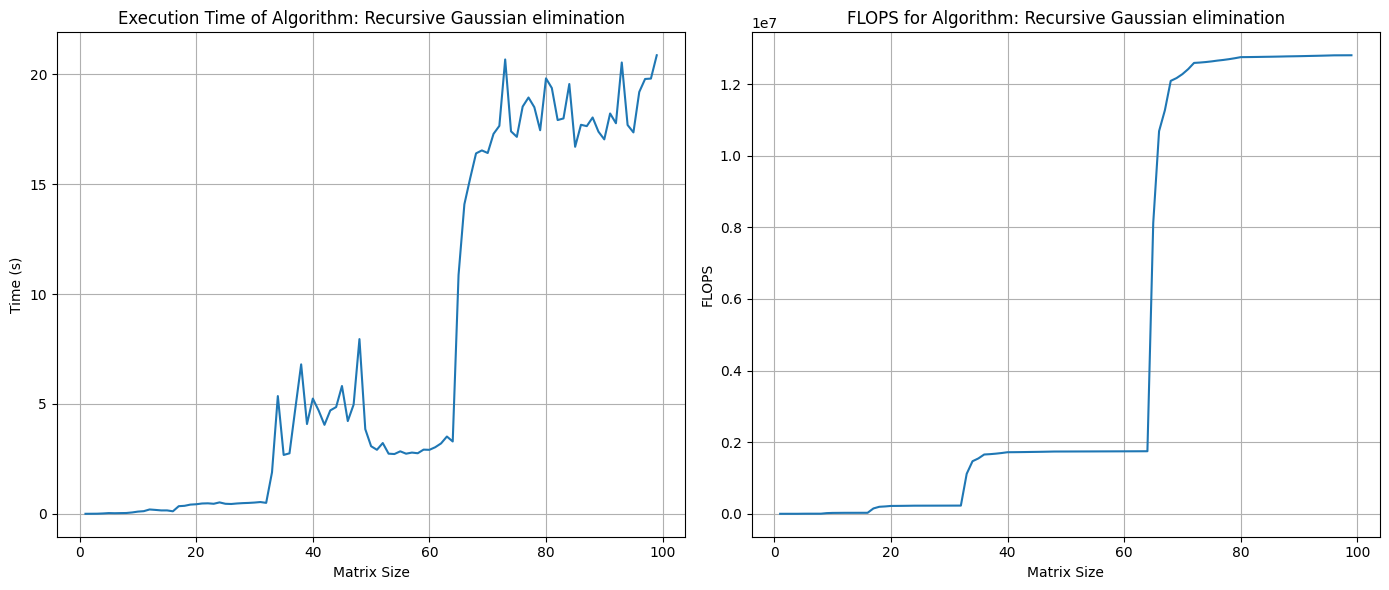

In [38]:
def measure_times_gauss(sizes):
    T_times = []
    T_flops = []
    
    for n in sizes:
        rng = np.random.default_rng()

        A = (rng.random((n, n)) * (1 - 1e-8) + 1e-8).astype(np.longdouble)
        B = (rng.random((n, 1)) * (1 - 1e-8) + 1e-8).astype(np.longdouble)
        
        global flops
        flops = 0
        start_time = time.time()
        g_res, b_res = Gauss_recursive(A,B,strassen_alg) 
        print(n, end = ' ')
        
        T_times.append(time.time() - start_time)
        
        solve1 = np.linalg.solve(g_res.astype(np.double),b_res.astype(np.double))
        solve2 = np.linalg.solve(A.astype(np.double),B.astype(np.double))
        assert abs(solve1-solve2.flatten()).max() <= 1e-3
        
        T_flops.append(flops)
        
    return T_times, T_flops

sizes = list(range(1, 100))  
gauss_times, gauss_flops = measure_times_gauss(sizes)
plot_times(sizes, gauss_times, gauss_flops, "Recursive Gaussian elimination", const = 18)

1 0.7924093111781628
2 -0.09892245497479564
3 -0.19601975951226816
4 0.33504678616743166
5 -0.10653808942279659
6 0.009260470920695771
7 0.0060609030770553815
8 0.04864552760614232
9 0.040025651922711326
10 0.03215018015779647
11 -0.025202039515968826
12 0.023051590777153106
13 0.0011307397392263747
14 0.04107726243399023
15 -0.013698130520328302
16 -0.0067616493407579225
17 0.012758380205126903
18 -0.057133033694815046
19 0.028982020859556396
20 -0.19662225608139122
21 0.19710834131288602
22 0.19127486899886129
23 0.02301378146644826
24 -0.20177934291791194
25 -0.9477295278729322
26 -2.4112252755022943
27 -3.2199984687509886
28 -1.822971910651784
29 0.14557113359123988
30 -1.2110817085384813
31 3.0414075784958214
32 2.8433632758592986
33 0.34086530890096456
34 23.818944852387837
35 123.06932187764849
36 15.011238448683972
37 -1.0509853403208766
38 -252.71399291987524
39 -9.668207541547515
40 -399.24777867171287
41 798.1171049340313
42 -765.1308886295482
43 -3721.307560996907
44 2443.9

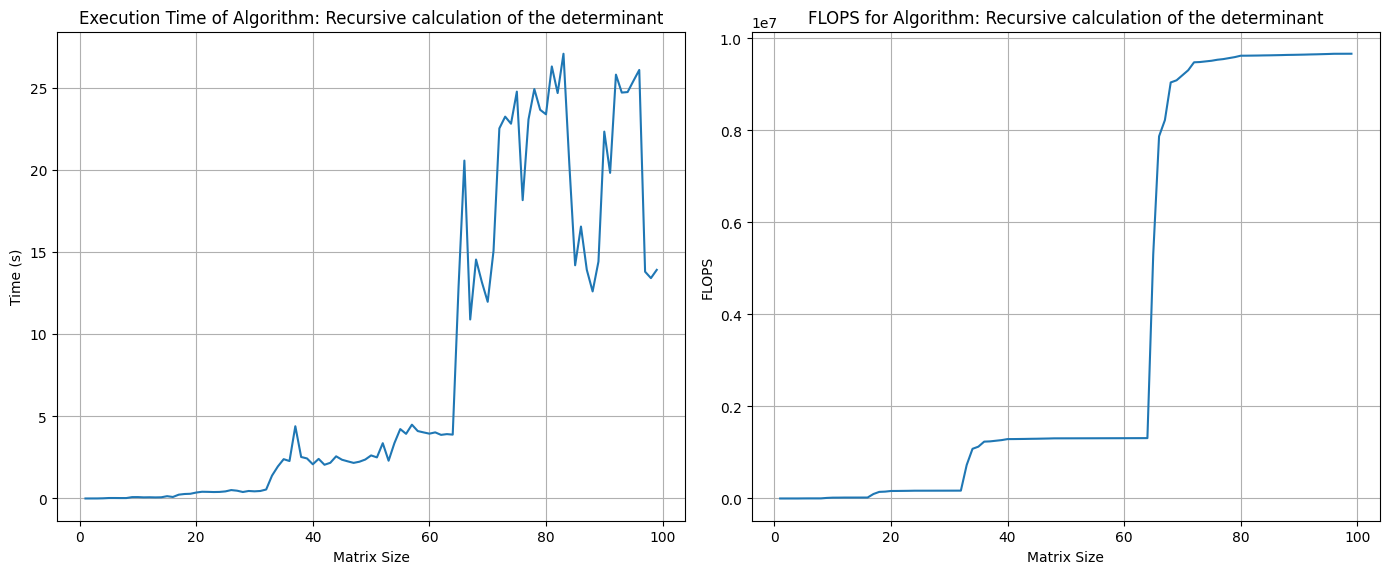

In [54]:
def measure_times_det(sizes):
    T_times = []
    T_flops = []
    
    for n in sizes:
        rng = np.random.default_rng()

        A = (rng.random((n, n)) * (1 - 1e-8) + 1e-8).astype(np.longdouble)
        B = (rng.random((n, 1)) * (1 - 1e-8) + 1e-8).astype(np.longdouble)
        
        global flops
        flops = 0
        start_time = time.time()
        det_A = determinant_recursive(A,strassen_alg) 
        print(n, end = ' ')

        T_times.append(time.time() - start_time)
        #print(det_A)
        assert abs(det_A - np.linalg.det(A.astype(np.double))) <= abs(det_A/100.0)
        
        T_flops.append(flops)
        
    return T_times, T_flops

sizes = list(range(1, 100))  
det_times, det_flops = measure_times_det(sizes)
plot_times(sizes, det_times, det_flops, "Recursive calculation of the determinant", const = 13.4)

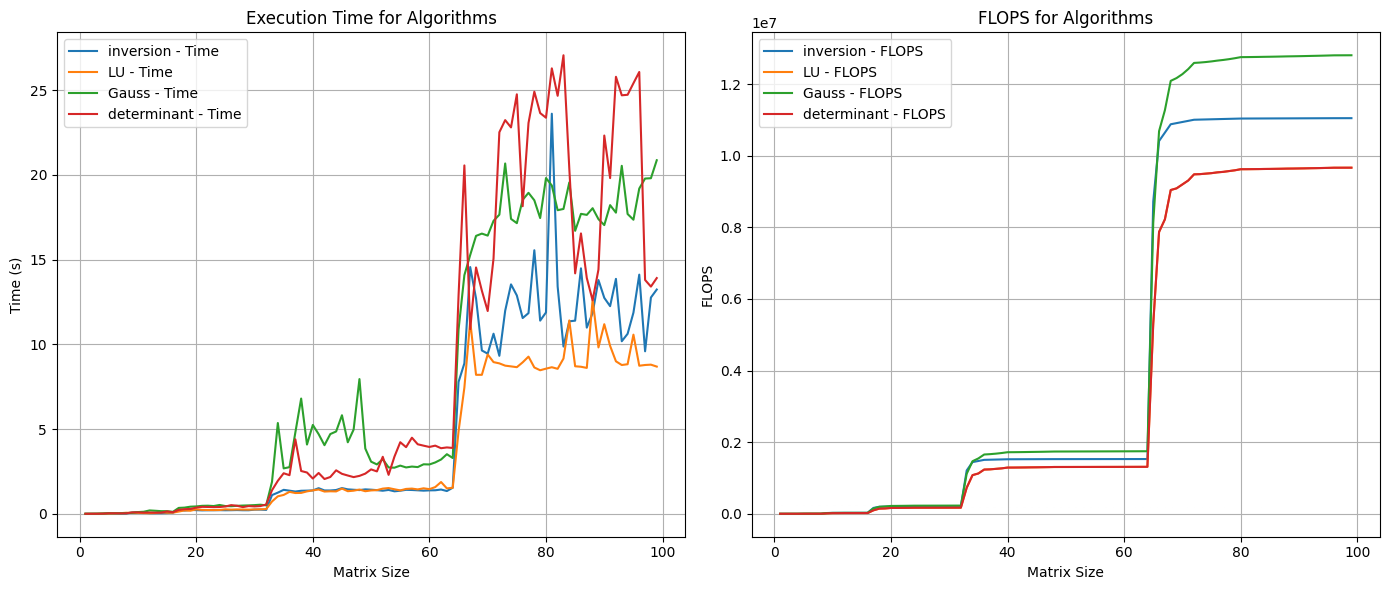

In [55]:
def plot_times_all(sizes, times_list, flops_list, algorithm_names):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    for times, name in zip(times_list, algorithm_names):
        ax1.plot(sizes, times, label=f'{name} - Time')
    ax1.set_xlabel('Matrix Size')
    ax1.set_ylabel('Time (s)')
    ax1.set_title('Execution Time for Algorithms')
    ax1.grid(True)
    ax1.legend()

    for flops, name in zip(flops_list, algorithm_names):
        ax2.plot(sizes, flops, label=f'{name} - FLOPS')
    ax2.set_xlabel('Matrix Size')
    ax2.set_ylabel('FLOPS')
    ax2.set_title('FLOPS for Algorithms')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_times_all(sizes, [inverse_times, lu_times, gauss_times, det_times], [inverse_flops, lu_flops, gauss_flops, det_flops], ["inversion", "LU", "Gauss", "determinant"])